## Emojify!
Welcome to the third and last programming assignment! You are going to use word vector representations to build an Emojifier.

You will implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️).

By using word vectors, you'll see that even if your training set explicitly relates only a few words to a particular emoji, your algorithm will be able to generalize and associate words in the test set to the same emoji even if those words don't even appear in the training set. This allows you to build an accurate classifier mapping from sentences to emojis, even using a small training set.

## Packages

Let's first import all the packages that you will need during this part of assignment.

Feel free to use another libraries if you want to.

If you don't have emoji or other libraries, write "pip install emoji" command in one of the code cells in the notebook. 

In [1]:
#pip install emoji

In [2]:
import numpy as np
import pandas as pd
import torch as torch
import torch.nn as nn
from torchvision import models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import emoji
import os
from collections import Counter

c:\Users\almog\OneDrive\Documents\deep-learning-emojify\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


General Params

In [3]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
batch_size = 32
epochs = 120
num_workers = 0
test_sentences = np.array(["French macaroon is so tasty", "Let us go play baseball", "I am upset", "Good joke", "work is horrible"])
#test_sentences = np.array(["I love my grandpa","Daniel eat only sushi", "I did my homework", "my grandpa is sick","kick the ball"])

graph loss_vs_epochs

In [4]:
def loss_vs_epochs(train_losses_list, test_losses_list):
    plt.figure(figsize = (15,5))
    plt.plot(train_losses_list, label = 'Train Loss', c = 'red')
    plt.plot(test_losses_list, label = 'Test Loss', c = 'blue')
    plt.title('Train Loss VS & Test Loss per Epoch')
    plt.xlabel = ("Epoch")
    plt.ylabel = ("Loss")
    plt.ylim(0.03, 0.06)
    plt.legend()
    plt.show()

## Import and visualize the data

In this part you need to:
1. Import the train and test data
2. Seperate the sentences (in the first column) and the index of the emoji (in the second column).
3. Convert the Y value of every sentence from emoji index (0-4) to one hot encoding. 2 --> [0,0,1,0,0]
4. Print 10 sentances from training data and visualize their matching emojies using the label_to_emoji() help function. Print also the one-hot-encoding representation of these sentences.

In [5]:
### START CODE HERE ###
#from google.colab import drive
#drive.mount("/content/drive")
#path = "/content/drive/MyDrive/Colab Notebooks"

In [6]:
emoji_dictionary = {"0": "\u2764\uFE0F",   
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], language='alias')

In [7]:
# 1. Import the train and test data
train_data = pd.read_csv("train_emoji.csv", header=None)
test_data = pd.read_csv("test_emoji.csv", header=None)
#train_data = pd.read_csv(path + "/train_emoji.csv", header=None)
#test_data = pd.read_csv(path + "/test_emoji.csv", header=None)

# 2. Seperate the sentences (in the first column) and the index of the emoji (in the second column).
train_data_x, train_data_y = train_data.iloc[:, 0].to_numpy(), train_data.iloc[:, 1].to_numpy(), 
test_data_x, test_data_y = test_data.iloc[:, 0].to_numpy(), test_data.iloc[:, 1].to_numpy(), 

# 3. Convert the Y value of every sentence from emoji index (0-4) to one hot encoding. 2 --> [0,0,1,0,0]
def index_to_one_hot_encoding(Y, length):
  return np.eye(length)[Y.reshape(-1)]

length = 5
train_data_y_onehot_encoded = index_to_one_hot_encoding(train_data_y, length)
test_data_y_onehot_encoded = index_to_one_hot_encoding(test_data_y, length)

# 4. Print 10 sentances from training data and visualize their matching emojies using the label_to_emoji() help function. Print also the one-hot-encoding representation of these sentences.
for index in range(10):
  print(f"#{index}  {label_to_emoji(train_data_y[index])}  {train_data_x[index]}")


#0  🍴  French macaroon is so tasty
#1  😞  work is horrible
#2  😞  I am upset
#3  ⚾  throw the ball
#4  😄  Good joke
#5  ⚾  what is your favorite baseball game
#6  🍴  I cooked meat
#7  😞  stop messing around
#8  🍴  I want chinese food
#9  ⚾  Let us go play baseball


## Help functions for word embedding

The following functions will help you conver words and sentences to vectors and matrixes.

In [8]:
# A function that obtains vector representations for words. Each word is represented by vector with size 50.
# words_to_index is a dictionary that maps word into indexes - every word has a number. 'banana' --> 67752
# index_to_words is a dictionary that maps indexes into indexes - every index has a matching word. 344429 --> 'strawberry'

def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


In [9]:
# load word embeddings and create word_to_index and index_to_word dictionaries

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [10]:
# visualization: 

print(f"The vector embedding of banana is: {word_to_vec_map['banana']}")
print(f"The index of the word 'tree' is: {word_to_index['tree']}")
print(f"The word matcing the index 173081 is: {index_to_word[173081]}")

The vector embedding of banana is: [-0.25522  -0.75249  -0.86655   1.1197    0.12887   1.0121   -0.57249
 -0.36224   0.44341  -0.12211   0.073524  0.21387   0.96744  -0.068611
  0.51452  -0.053425 -0.21966   0.23012   1.043    -0.77016  -0.16753
 -1.0952    0.24837   0.20019  -0.40866  -0.48037   0.10674   0.5316
  1.111    -0.19322   1.4768   -0.51783  -0.79569   1.7971   -0.33392
 -0.14545  -1.5454    0.0135    0.10684  -0.30722  -0.54572   0.38938
  0.24659  -0.85166   0.54966   0.82679  -0.68081  -0.77864  -0.028242
 -0.82872 ]
The index of the word 'tree' is: 364528
The word matcing the index 173081 is: happy


In [11]:
# A function that translates the sentences vectors of word indexes --> I love you --> [185457,226278,394475]
# the function uses padding of the longes sentence in the train set, so I love you --> [185457,226278,394475,0,0,0,0,0,0,0]

def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    for i in range(m):
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            X_indices[i, j] = int(word_to_index[w])
            j = j + 1
    return X_indices

sentences_to_indices(np.array(['hello world']),word_to_index,4)

array([[176468., 389938.,      0.,      0.]])

In [12]:
# function that maps all the word indexes to their vectors embedding. 
# the embedding function is in shape (400000, 50) - each word is a vector in size 50.

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1  #word index begin with 1,plus 1 for padding 0
    emb_dim = word_to_vec_map["cucumber"].shape[0] # the size of embedding of each word
    emb_matrix = np.zeros((vocab_len, emb_dim))
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    return emb_matrix


## Train and test data preprocessing

The models that you will build will get the sentences as their vector representations - i.e., the sentences_to_indices() function output. 

Therefore, you need to:
* Transform the data to the right form using the above functions
* Transform the data and lables to tensors
* If needed, create train and test data loaders

In [13]:
### START CODE HERE ###
# 1. Transform the data to the right form using the above functions
# First, find the max sentence lenght
longest_sentence = max(train_data_x, key=len)
max_sentence_len = len(longest_sentence.split())

# Now, convert the sentences to indexes vectors by the function "sentences_to_indices"
train_data_to_indices = sentences_to_indices(train_data_x, word_to_index, max_sentence_len)
test_data_to_indices = sentences_to_indices(test_data_x, word_to_index, max_sentence_len)

In [14]:
# 2. Transform the data and lables to tensors
# train data set
train_data_x_tensor = torch.from_numpy(train_data_to_indices)
train_data_y_tensor = torch.from_numpy(train_data_y)
train_data_tensor = torch.utils.data.TensorDataset(train_data_x_tensor, train_data_y_tensor)

# train data set
test_data_x_tensor = torch.from_numpy(test_data_to_indices)
test_data_y_tensor = torch.from_numpy(test_data_y)
test_data_tensor = torch.utils.data.TensorDataset(test_data_x_tensor, test_data_y_tensor)

In [15]:
# 3. create train and test data 
train_loader = torch.utils.data.DataLoader(dataset=train_data_tensor, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset=test_data_tensor, batch_size=batch_size, num_workers=num_workers)

# First model - regular neural network

Build a neural network model that gets:

1. The vocabulary size
2. Embedding dimention - the length of every embedding vector
3. Pretrained embedding weights - the embedding matrix 
                                       
and returns: 
1. 5 dimention vector with the scores of every emoji.


---

Then train the model and plot loss vs. epoch for train and test set. 

Show the results on 5 new sentences.


---

You can use the added model as your base model

In [16]:
### START CODE HERE ###
def train_model(name, device, epochs, train_loader, test_loader, model, optimizer, loss_func, train_x_tensor, test_x_tensor, array_of_sentences):
  
  train_loss_list = []
  train_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []
  predictive_sentence_index = []
  check_train = {index:[] for index in range(0,5)}
  check = {index:[] for index in range(0,5)}

  for e in range(epochs):
    train_loss_calc = 0
    test_loss_calc = 0
    train_accuracy_calc = 0
    test_accuracy_calc = 0 

    # model.train()

    for train_inputs, train_labels in train_loader:
      train_inputs = Variable(train_inputs.long())
      train_labels = Variable(train_labels.long())
      optimizer.zero_grad() # Clear the gradients of all optimized variables
      if name == "RNN":
        train_h = (Variable(torch.zeros(2,len(train_inputs), 128)),Variable(torch.zeros(2,len(train_inputs), 128)))
        train_outputs = model(train_inputs, train_h) # Forward pass
      else:  
        train_outputs = model(train_inputs) # Forward pass
      loss = loss_func(train_outputs, train_labels) # Calculate the loss
      loss.backward()
      optimizer.step() # Doing the optimizer step
      train_loss_calc += loss.item() # Update running training loss
      model.train() # Actually training the net
      for i in range(len(train_inputs)):
        train_original_index = int(train_labels[i])
        train_predictive_index = int(np.argmax(train_outputs[i].detach().numpy()))
        check_train[train_original_index].append(train_predictive_index)
        if train_original_index == train_predictive_index:
          train_accuracy_calc += 1

    # Update lists  
    train_loss_calc /= len(train_loader.dataset)
    train_accuracy_calc /= len(train_x_tensor)
    train_loss_list.append(train_loss_calc)
    train_accuracy_list.append(train_accuracy_calc)    
      
    #model.eval()
      
    with torch.no_grad():
      model.eval()
      for test_input, test_labels in test_loader:
        test_input = Variable(test_input.long())
        test_labels = Variable(test_labels.long())
        if name == "RNN":
          test_h = (Variable(torch.zeros(2,len(test_input), 128)),Variable(torch.zeros(2,len(test_input), 128)))
          test_outputs = model(test_input, test_h) # Forward pass
        else:
          test_outputs = model(test_input) # Forward pass
        test_loss_calc += loss_func(test_outputs, test_labels).item() # Update running training loss
        for i in range(len(test_input)):
          test_original_index = int(test_labels[i])
          test_predictive_index = int(np.argmax(test_outputs[i].detach().numpy()))
          #print(test_original_index, test_predictive_index)
          #print(type(test_predictive_index), type(test_predictive_index))
          check[test_original_index].append(test_predictive_index)
          if test_original_index == test_predictive_index:
            #print("YES")
            test_accuracy_calc += 1

      test_loss_calc /= len(test_loader.dataset)
      test_accuracy_calc /= len(train_x_tensor)
      test_loss_list.append(test_loss_calc)
      test_accuracy_list.append(test_accuracy_calc)
        

    if e % 10 == 0:
      print(f"Epoch:{e + 1}/{epochs} \tTrain Loss:{round(train_loss_calc, 5)} \tTrain Accuracy:{round(train_accuracy_calc, 5)} \tTest Loss:{round(test_loss_calc, 5)} \tTest Accuracy:{round(test_accuracy_calc, 5)}")
  
  test_sentences_indices = sentences_to_indices(array_of_sentences, word_to_index,len(max(test_sentences, key=len).split()))
  test_sentences_indices = Variable(torch.from_numpy(test_sentences_indices).long())
  if name == "RNN":
    h = (Variable(torch.zeros(2,5,128)),Variable(torch.zeros(2,5,128)))
    outputs = model(test_sentences_indices, h)
  else:  
    outputs = model(test_sentences_indices)
  for i in range(len(array_of_sentences)):
    test_predictive_index = int(np.argmax(outputs.detach().numpy()[i]))
    predictive_sentence_index.append(test_predictive_index)

  return train_loss_list, train_accuracy_list, test_loss_list, test_loss_list, model, predictive_sentence_index, check_train, check

In [17]:
class NN_Model(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,pretrained_weight):
        super(NN_Model,self).__init__()
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim) # stores embeddings of a fixed dictionary and size
        self.word_embeds.weight.data.copy_(torch.from_numpy(pretrained_weight)) # place the pretrained weights to the embedding function
        self.layers = nn.Sequential(
        nn.Linear(embedding_dim, embedding_dim//2), 
        nn.ReLU(),
        nn.Linear(embedding_dim//2, embedding_dim//4),
        nn.ReLU(),
        nn.Linear(embedding_dim//4, 5),
        nn.Softmax(dim=1)
        )

    def forward(self,x):
        out = self.word_embeds(x) 
        # out = torch.flatten(out, start_dim=1)
        out = out[:,-1,:]
        out = self.layers(out)
        return out

In [18]:
vocabulary_leb_1st = len(word_to_index) + 1
pretrained_weight_1st = pretrained_embedding_layer(word_to_vec_map, word_to_index)
embedding_dim_1st = pretrained_weight_1st.shape[1]

In [19]:
model_1st = NN_Model(vocabulary_leb_1st, embedding_dim_1st, pretrained_weight_1st)
model_1st

NN_Model(
  (word_embeds): Embedding(400001, 50)
  (layers): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=5, bias=True)
    (5): Softmax(dim=1)
  )
)

In [20]:
for param in model_1st.parameters():
    param.requires_grad = True

In [21]:
optimizer_1st = torch.optim.Adam(model_1st.parameters(),lr=0.0001)
loss_func_1st = torch.nn.CrossEntropyLoss().to(device)

In [22]:
train_losses_list_1st, train_accuracy_list_1st, test_losses_list_1st, test_accuracy_list_1st, \
trained_model_1st, predictive_sentence_index_1st, check_train_1st, check_test_1st = \
train_model("NN", device, epochs, train_loader, test_loader, model_1st, optimizer_1st, loss_func_1st, train_data_x_tensor, test_data_x_tensor, test_sentences)

In [23]:
loss_vs_epochs(train_losses_list_1st, test_losses_list_1st)

In [24]:
for i in range(len(test_sentences)):
    print(f"#{i+1}  {label_to_emoji(predictive_sentence_index_1st[i])}  {test_sentences[i]}")
    

In [ ]:
for key, value in check_train_1st.items():
    print(key, Counter(check_train_1st[key]))

# Second model - neural network with RNN

Build a neural network + RNN model that gets the vocabulary size, embedding dimention and pretrained embedding weights, and returns a 5 dimention vector with the scores of every emoji.

Then train the model and plot loss vs. epoch for train and test set.

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

---

You can use the added model as your base model

In [25]:
class RNN_Model(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,pretrained_weight):
        super(RNN_Model,self).__init__()
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim) # stores embeddings of a fixed dictionary and size
        self.word_embeds.weight.data.copy_(torch.from_numpy(pretrained_weight)) # place the pretrained weights to the embedding function
        self.rnn = nn.LSTM(embedding_dim, 128, 2,batch_first = True, dropout = 0.5) 
        self.layers = nn.Sequential(
         nn.Linear(128,64),
         nn.ReLU(),
         nn.Linear(64,32),
         nn.ReLU(),
         nn.Linear(32,10),
         nn.ReLU(),
         nn.Linear(10,5),
         nn.Softmax(dim = 1)
        )

    def forward(self,x,h):
        out = self.word_embeds(x)
        out, _ = self.rnn(out,h)
        out = out[:, -1, :]
        out = self.layers(out)
        return out

In [26]:
model_2nd = RNN_Model(vocabulary_leb_1st, embedding_dim_1st, pretrained_weight_1st)
model_2nd

RNN_Model(
  (word_embeds): Embedding(400001, 50)
  (rnn): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.5)
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): Softmax(dim=1)
  )
)

In [27]:
for param in model_2nd.parameters():
    param.requires_grad = True

In [28]:
optimizer_2nd = torch.optim.Adam(model_2nd.parameters(),lr=0.0001)
loss_func_2nd = torch.nn.CrossEntropyLoss().to(device)

In [29]:
# 3. create train and test data 
train_loader_2nd = torch.utils.data.DataLoader(dataset=train_data_tensor, batch_size=batch_size, num_workers=num_workers)
test_loader_2nd = torch.utils.data.DataLoader(dataset=test_data_tensor, batch_size=batch_size, num_workers=num_workers)

In [30]:
train_losses_list_2nd, train_accuracy_list_2nd, test_losses_list_2nd, test_accuracy_list_2nd, \
trained_model_2nd, predictive_sentence_index_2nd, check_train_2nd, check_test_2nd = \
train_model("RNN", device, epochs, train_loader_2nd, test_loader_2nd, model_2nd, optimizer_2nd, loss_func_2nd, train_data_x_tensor, test_data_x_tensor, test_sentences)

Epoch:1/120 	Train Loss:0.05268 	Train Accuracy:0.28415 	Test Loss:0.05737 	Test Accuracy:0.08743
Epoch:11/120 	Train Loss:0.0526 	Train Accuracy:0.28415 	Test Loss:0.05727 	Test Accuracy:0.08743
Epoch:21/120 	Train Loss:0.05189 	Train Accuracy:0.30601 	Test Loss:0.05636 	Test Accuracy:0.09836
Epoch:31/120 	Train Loss:0.05102 	Train Accuracy:0.30601 	Test Loss:0.05527 	Test Accuracy:0.09836
Epoch:41/120 	Train Loss:0.0508 	Train Accuracy:0.30601 	Test Loss:0.05502 	Test Accuracy:0.09836
Epoch:51/120 	Train Loss:0.05073 	Train Accuracy:0.30601 	Test Loss:0.05495 	Test Accuracy:0.09836
Epoch:61/120 	Train Loss:0.0507 	Train Accuracy:0.30601 	Test Loss:0.05492 	Test Accuracy:0.09836
Epoch:71/120 	Train Loss:0.05069 	Train Accuracy:0.30601 	Test Loss:0.0549 	Test Accuracy:0.09836
Epoch:81/120 	Train Loss:0.05068 	Train Accuracy:0.30601 	Test Loss:0.05489 	Test Accuracy:0.09836
Epoch:91/120 	Train Loss:0.05067 	Train Accuracy:0.30601 	Test Loss:0.05488 	Test Accuracy:0.09836
Epoch:101/120 	

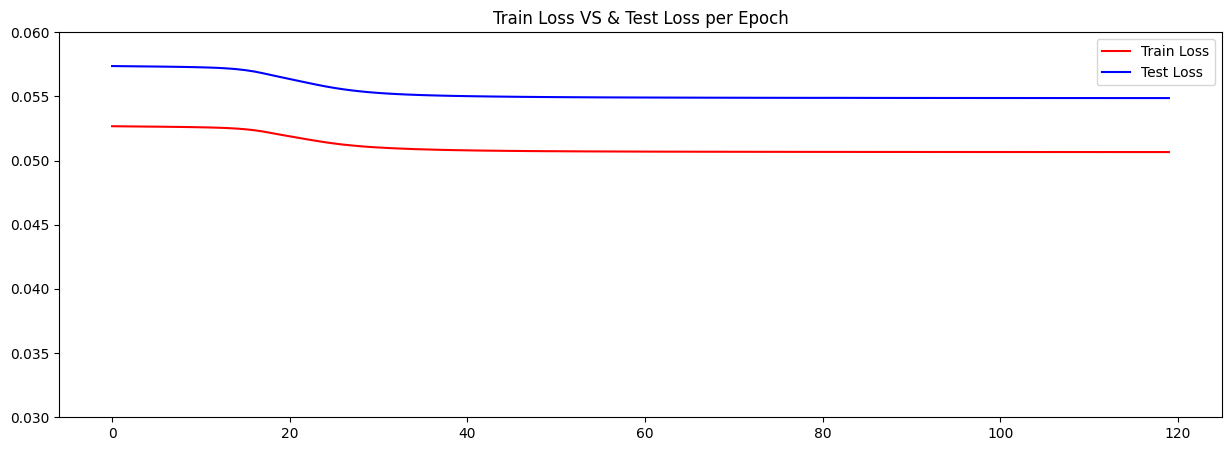

In [31]:
loss_vs_epochs(train_losses_list_2nd, test_losses_list_2nd)

In [32]:
for i in range(len(test_sentences)):
    print(f"#{i+1}  {label_to_emoji(predictive_sentence_index_2nd[i])}  {test_sentences[i]}")
    

#1  😄  French macaroon is so tasty
#2  😄  Let us go play baseball
#3  😄  I am upset
#4  😄  Good joke
#5  😄  work is horrible


In [34]:
for key, value in check_train_2nd.items():
    print(key, Counter(check_train_2nd[key]))

0 Counter({2: 3322, 3: 638})
1 Counter({2: 1910, 3: 370})
2 Counter({2: 5633, 3: 1087})
3 Counter({2: 5236, 3: 1004})
4 Counter({2: 2314, 3: 446})


In [35]:
for key, value in check_test_2nd.items():
    print(key, Counter(check_test_2nd[key]))

0 Counter({2: 707, 3: 133})
1 Counter({2: 808, 3: 152})
2 Counter({2: 1818, 3: 342})
3 Counter({2: 1616, 3: 304})
4 Counter({2: 707, 3: 133})


# Third model - neural network with transformers

Build a neural network + transformer model that gets the vocabulary size, embedding dimention and pretrained embedding weights, and returns a 5 dimention vector with the scores of every emoji.

Then train the model and plot loss vs. epoch for train and test set.

https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html


---

You can use the added model as your base model

In [36]:
### START CODE HERE ###

In [37]:
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [38]:
class Transformer_model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pretrained_weight, transformer_dim):
        super(Transformer_model,self).__init__()
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(pretrained_weight))
        self.pos_encoding = PositionalEncoding(embedding_dim)
        self.transformer = nn.Transformer(d_model=transformer_dim, nhead=5, num_encoder_layers=1, num_decoder_layers=1)
        self.attention = nn.MultiheadAttention(embed_dim=transformer_dim, num_heads=5)
        self.embeds_to_transformer = nn.Linear(embedding_dim, transformer_dim)
        self.layers = nn.Sequential(
            nn.Linear(transformer_dim, transformer_dim//2),
            nn.ReLU(),
            nn.Linear(transformer_dim//2,transformer_dim//4),
            nn.ReLU(),
            nn.Linear(transformer_dim//4, transformer_dim//6),
            nn.ReLU(),
            nn.Linear(transformer_dim//6 ,5),
            nn.Softmax(dim = 1)
        )
        
    def forward(self,x):
        out = self.word_embeds(x)
        out += self.pos_encoding(out)
        out = self.embeds_to_transformer(out)
        out = self.transformer(out, out)
        out = torch.sum(out, axis = 1)
        out = self.layers(out)
        return out



In [39]:
transformer_dim = 100

In [40]:
model_3rd = Transformer_model(vocabulary_leb_1st, embedding_dim_1st, pretrained_weight_1st, transformer_dim)
model_3rd

Transformer_model(
  (word_embeds): Embedding(400001, 50)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
          )
          (linear1): Linear(in_features=100, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=100, bias=True)
          (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): Transform

In [41]:
for param in model_3rd.parameters():
    param.requires_grad = True

In [42]:
optimizer_3rd = torch.optim.Adam(model_3rd.parameters(),lr=0.0001)
loss_func_3rd = torch.nn.CrossEntropyLoss().to(device)

In [43]:
# 2. Transform the data and lables to tensors
# train data set
train_data_x_tensor_3rd = torch.from_numpy(train_data_to_indices)
train_data_y_tensor_3rd = torch.from_numpy(train_data_y)
train_data_tensor_3rd = torch.utils.data.TensorDataset(train_data_x_tensor_3rd, train_data_y_tensor_3rd)

# train data set
test_data_x_tensor_3rd = torch.from_numpy(test_data_to_indices)
test_data_y_tensor_3rd = torch.from_numpy(test_data_y)
test_data_tensor_3rd = torch.utils.data.TensorDataset(test_data_x_tensor_3rd, test_data_y_tensor_3rd)

In [44]:
# 3. create train and test data 
train_loader_3rd = torch.utils.data.DataLoader(dataset=train_data_tensor_3rd, batch_size=batch_size, num_workers=num_workers)
test_loader_3rd = torch.utils.data.DataLoader(dataset=test_data_tensor_3rd, batch_size=batch_size, num_workers=num_workers)

In [45]:
#train_losses_list_3rd, train_accuracy_list_3rd, test_losses_list_3rd, test_accuracy_list_3rd, trained_model_3rd, predictive_sentence_index_3rd = \
#train_model("Transformer", device, epochs, train_loader_3rd, test_loader_3rd, model_3rd, optimizer_3rd, loss_func_3rd, train_data_x_tensor_3rd, test_data_x_tensor_3rd, test_sentences)

In [46]:
#loss_vs_epochs(train_losses_list_3rd, test_losses_list_3rd)

In [47]:
#for i in range(len(test_sentences)):
#    print(f"#{i+1}  {label_to_emoji(predictive_sentence_index_3rd[i])}  {test_sentences[i]}")
    

### Compare between the models - who had the best results? Try to explain why. 

Write your answere here

Archive

In [48]:
### START CODE HERE ###
def train_model_2(device, epochs, train_loader, test_loader, model, optimizer, loss_func, train_x_tensor, test_x_tensor, array_of_sentences):
  
  train_loss_list = []
  train_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []
  predictive_sentence_index = []

  for e in range(epochs):
    train_loss_calc = 0
    test_loss_calc = 0
    train_accuracy_calc = 0
    test_accuracy_calc = 0 

    #model.train()

    for train_inputs, train_labels in train_loader:
      train_inputs = Variable(train_inputs.long())
      train_labels = Variable(train_labels.long())
      optimizer.zero_grad() # Clear the gradients of all optimized variables
      train_outputs = model(train_inputs) # Forward pass
      loss = loss_func(train_outputs, train_labels) # Calculate the loss
      loss.backward()
      optimizer.step() # Doing the optimizer step
      train_loss_calc += loss.item() # Update running training loss
      model.train() # Actually training the net
      for i in range(len(train_inputs)):
        train_original_index = train_labels[i]
        train_predictive_index = np.argmax(train_outputs[i].detach().numpy())
        if train_original_index == train_predictive_index:
          train_accuracy_calc += 1

    # Update lists  
    train_loss_calc /= len(train_loader.dataset)
    train_accuracy_calc /= len(train_x_tensor)
    train_loss_list.append(train_loss_calc)
    train_accuracy_list.append(train_accuracy_calc)    
      
    #model.eval()
      
    with torch.no_grad():
      for test_input, test_labels in test_loader:
        test_input = Variable(test_input.long())
        test_labels = Variable(test_labels.long())
        test_outputs = model(test_input) # Forward pass
        test_loss_calc += loss_func(test_outputs, test_labels).item() # Update running training loss
        for i in range(len(test_input)):
          test_original_index = test_labels[i]
          test_predictive_index = np.argmax(test_outputs[i].detach().numpy())
          #a =np.argmax(pred_2[i])
          if test_original_index == test_predictive_index:
            test_accuracy_calc += 1

      test_loss_calc /= len(test_loader.dataset)
      test_accuracy_calc /= len(train_x_tensor)
      test_loss_list.append(test_loss_calc)
      test_accuracy_list.append(test_accuracy_calc)
        

    if e % 10 == 0:
      print(f"Epoch:{e + 1}/{epochs} \tTrain Loss:{round(train_loss_calc, 5)} \tTrain Accuracy:{round(train_accuracy_calc, 5)} \tTest Loss:{round(test_loss_calc, 5)} \tTest Accuracy:{round(test_accuracy_calc, 5)}")
  
  test_sentences_indices = sentences_to_indices(array_of_sentences, word_to_index,len(max(test_sentences, key=len).split()))
  test_sentences_indices = Variable(torch.from_numpy(test_sentences_indices).long())
  outputs = model(test_sentences_indices)
  for i in range(len(array_of_sentences)):
    test_predictive_index = np.argmax(outputs.detach().numpy()[i])
    predictive_sentence_index.append(test_predictive_index)

  return train_loss_list, train_accuracy_list, test_loss_list, test_loss_list, model, predictive_sentence_index


#Show the results on 5 new sentences.
def show_result(array_of_sentences, model):
  test_sentences_indices = sentences_to_indices(array_of_sentences, word_to_index,len(max(test_sentences, key=len).split()))
  test_sentences_indices = Variable(torch.from_numpy(test_sentences_indices).long())
  outputs = model(test_sentences_indices)
  for i in range(len(array_of_sentences)):
    test_predictive_index = np.argmax(outputs.detach().numpy()[i])
    # print(test_sentences[i], label_to_emoji(test_predictive_index),", the predictions:", [round(x,4) for x in outputs[i].tolist()])
    print(f"#{i+1}  {label_to_emoji(test_predictive_index)}  {array_of_sentences[i]}")


### START CODE HERE ###
def train_model_3(device, epochs, train_loader, test_loader, model, optimizer, loss_func, train_x_tensor, test_x_tensor, array_of_sentences):
  
  train_loss_list = []
  train_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []
  predictive_sentence_index = []

  for e in range(epochs):
    train_loss_calc = 0
    test_loss_calc = 0
    train_accuracy_calc = 0
    test_accuracy_calc = 0 

    # model.train()

    for train_inputs, train_labels in train_loader:
      train_inputs = Variable(train_inputs.long())
      train_labels = Variable(train_labels.long())
      optimizer.zero_grad() # Clear the gradients of all optimized variables
      train_h = (Variable(torch.zeros(2,len(train_inputs), 128)),Variable(torch.zeros(2,len(train_inputs), 128)))
      train_outputs = model(train_inputs, train_h) # Forward pass
      loss = loss_func(train_outputs, train_labels) # Calculate the loss
      loss.backward()
      optimizer.step() # Doing the optimizer step
      train_loss_calc += loss.item() # Update running training loss
      model.train() # Actually training the net
      for i in range(len(train_inputs)):
        train_original_index = train_labels[i]
        train_predictive_index = np.argmax(train_outputs[i].detach().numpy())
        if train_original_index == train_predictive_index:
          train_accuracy_calc += 1

    # Update lists  
    train_loss_calc /= len(train_loader.dataset)
    train_accuracy_calc /= len(train_x_tensor)
    train_loss_list.append(train_loss_calc)
    train_accuracy_list.append(train_accuracy_calc)    
      
    # model.eval()
      
    with torch.no_grad():
      for test_input, test_labels in test_loader:
        test_input = Variable(test_input.long())
        test_labels = Variable(test_labels.long())
        test_h = (Variable(torch.zeros(2,len(test_input), 128)),Variable(torch.zeros(2,len(test_input), 128)))
        test_outputs = model(test_input, test_h) # Forward pass
        test_loss_calc += loss_func(test_outputs, test_labels).item() # Update running training loss
        for i in range(len(test_input)):
          test_original_index = test_labels[i]
          test_predictive_index = np.argmax(test_outputs[i].detach().numpy())
          if test_original_index == test_predictive_index:
            test_accuracy_calc += 1

      test_loss_calc /= len(test_loader.dataset)
      test_accuracy_calc /= len(train_x_tensor)
      test_loss_list.append(test_loss_calc)
      test_accuracy_list.append(test_accuracy_calc)      

    if e % 10 == 0:
      print(f"Epoch:{e + 1}/{epochs} \tTrain Loss:{round(train_loss_calc, 5)} \tTrain Accuracy:{round(train_accuracy_calc, 5)} \tTest Loss:{round(test_loss_calc, 5)} \tTest Accuracy:{round(test_accuracy_calc, 5)}")
  
  test_sentences_indices = sentences_to_indices(array_of_sentences, word_to_index, len(max(test_sentences, key=len).split()))
  test_sentences_indices = Variable(torch.from_numpy(test_sentences_indices).long())
  h = (Variable(torch.zeros(2,5,128)),Variable(torch.zeros(2,5,128)))
  outputs = model(test_sentences_indices, h)
  for i in range(len(array_of_sentences)):
    test_predictive_index = np.argmax(outputs.detach().numpy()[i])
    predictive_sentence_index.append(test_predictive_index)

  return train_loss_list, train_accuracy_list, test_loss_list, test_loss_list, model, predictive_sentence_index

#Show the results on 5 new sentences.
def show_result_2(array_of_sentences, model):
  test_sentences_indices = sentences_to_indices(array_of_sentences, word_to_index, len(max(test_sentences, key=len).split()))
  test_sentences_indices = Variable(torch.from_numpy(test_sentences_indices).long())
  h = (Variable(torch.zeros(2,5,128)),Variable(torch.zeros(2,5,128)))
  outputs = model(test_sentences_indices, h)
  for i in range(len(array_of_sentences)):
    test_predictive_index = np.argmax(outputs.detach().numpy()[i])
    print(f"#{i+1}  {label_to_emoji(test_predictive_index)}  {array_of_sentences[i]}")